<a href="https://colab.research.google.com/github/ricardocastillov/Diplomado/blob/main/Clasificaci%C3%B3n_RX_Neumot%C3%B3rax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelo de Clasificación para análisis de  Radiografías de Tórax Normal versus Neumotorax:

**OBJETIVO**

El objetivo es desarrollar y evaluar un modelo de clasificación binaria, que permita clasificar si las radiografias de tórax evaluadas pueden ser clasificada como NORMAL o NEUMOTORAX. Para el entrenamiento se usarán imagenes de radiografias reales anonimizadas con diagnostico realizados por un radiólogo.

**INTRODUCCION**

La radiografía de tórax es uno de los estudios más solicitados, para multiples diagnosticos que afectan al sistema respiratorio y caja toraxica. Multiples patologias como enfermedades infecciosas, oncologicas o traumaticas requieren de una radiografia de torax para su diagnostico inicial o su tratamiento. Ademas es un estudio de facil acceso por su costo y la presencia de equipos de rayos x en casi todos los sistemas de salud. El neumotorax es un hallazgo considerado critico y que requiere habitualmente hospitalizacion inmediata para realizar procedimientos para revertirlo cuando es de un tamaño que no permitiria su absorcion. Sin embargo, muchos servicios de salud no cuentan con suficientes radiologos y muchos de estos estudios no son informados, lo que puede afectar la atencion de estos pacientes. El desarrollo de un algoritmo que pueda clasificar las radiografias en NORMAL versus NEUMOTORAX podria permitir a clinicos tomar decisiones mientras los estudios son confirmados por el informe radiologico. Por esta razon el entrenamiento de un clasificador con redes neuronales (CNN Convolutional neural network), en este caso ResNet18 preentrenado en ImagenNet, que sea capaz de clasificar entre dos clases NORMAL versus NEUMOTORAX,  con buenos metricas de rendimiento como accuracy, precission, F1-score  y recall seria un aporte a la atencion de estos pacientes. Este modelo se indica el origen de los datos, la preparación de ellos para el entrenamiento, el preprocesamiento, arquitectura de la red e hiperparámetros; estrategia de partición; las métricas obtenidas y curvas de aprendizaje; evaluación en test; interpretación y limitaciones. El presente modelo no ha sido testeado en un escenario clinico.


##CARGA DE DATOS**

Carga de los datos desde Drive, donde se subieron imagenes de la RX de torax en formato PNG

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Subida de data desde drive

La carpeta de las imagenes tiene la siguiente estructura y esta en la siguienes direccion.
https://drive.google.com/drive/folders/1QnZ59d0FHuNPR7TLP9z-xQRlN1HHxqD6?usp=sharing

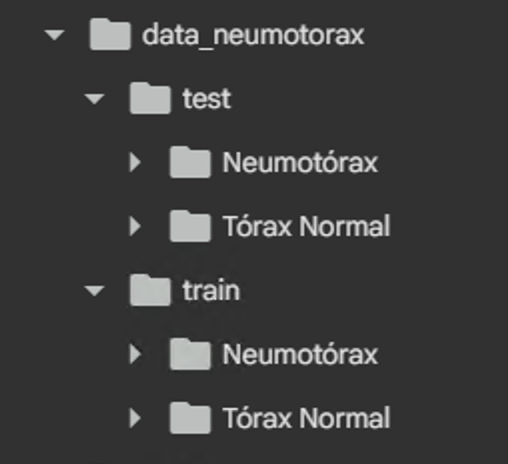

Los directorios de los dataset se describen a continuacion:

In [3]:
carpeta_dataset = '/content/drive/MyDrive/data_neumotorax'
carpeta_train = '/content/drive/MyDrive/data_neumotorax/train'
carpeta_test = '/content/drive/MyDrive/data_neumotorax/test'

## Preparacion del dataset
El código utiliza la biblioteca PyTorch y torchvision para preparar el conjunto de datos realizando las siguientes acciones:

Redimensiona las imagenes de manera que el tamaño de todas las imágenes sea de 224x224 píxeles (transforms.Resize). Este tamaño es común para modelos pre-entrenados como ResNet.

Convierte a tensor las imágenes en formato PIL (Python Imaging Library) a tensores de PyTorch (transforms.ToTensor). Esto es necesario para que PyTorch pueda procesarlas.

Normaliza los valores de los píxeles para que tengan una media (mean) y una desviación estándar (std) de 0.5. Esto ayuda a estabilizar el entrenamiento del modelo.

Utiliza datasets.ImageFolder para cargar automáticamente imágenes en carpetas. Esta función asume que las imágenes de cada clase están en una subcarpeta separada, y asigna una etiqueta (clase) a cada imagen basándose en el nombre de la carpeta.

dataset_train: Carga el conjunto de datos de entrenamiento desde la carpeta especificada por la variable carpeta_train.

dataset_val: Carga el conjunto de datos de validación desde la carpeta carpeta_test.



In [4]:
import torchvision
import torchvision.datasets as datasets
from torchvision import transforms

# Transformaciones: transformar a tensores y normalización
transform = transforms.Compose([
  transforms.Resize((224, 224)), # Add Resize transformation
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Creación de Dataset a partir de carpetas
dataset_train = datasets.ImageFolder(root=carpeta_train, transform=transform)
dataset_val = datasets.ImageFolder(root=carpeta_test, transform=transform)

# Atributos de dataset
print(dataset_train.classes) # Clases Disponibles
print(dataset_train.class_to_idx) # Indices y sus clases
print(dataset_train.imgs) # Lista de (imagen, clase)

['Neumotórax', 'Tórax Normal']
{'Neumotórax': 0, 'Tórax Normal': 1}
[('/content/drive/MyDrive/data_neumotorax/train/Neumotórax/1.2.392.200036.9125.4.0.1327732005.1795228672.2640263961-0.png', 0), ('/content/drive/MyDrive/data_neumotorax/train/Neumotórax/1.2.392.200036.9125.4.0.170450016.2197881856.2640263961-0.png', 0), ('/content/drive/MyDrive/data_neumotorax/train/Neumotórax/1.2.392.200036.9125.4.0.186875366.2499871744.2640263961-0.png', 0), ('/content/drive/MyDrive/data_neumotorax/train/Neumotórax/1.2.392.200036.9125.4.0.2351307614.117572608.2640263961-0.png', 0), ('/content/drive/MyDrive/data_neumotorax/train/Neumotórax/1.2.392.200036.9125.4.0.3726782194.1694565376.2640263961-0.png', 0), ('/content/drive/MyDrive/data_neumotorax/train/Neumotórax/1.2.392.200036.9125.4.0.3978745068.754975744.2640263961-0 2.png', 0), ('/content/drive/MyDrive/data_neumotorax/train/Neumotórax/1.2.392.200036.9125.4.0.3978745068.754975744.2640263961-0 3.png', 0), ('/content/drive/MyDrive/data_ne

## Creacion de DataLoardes
Se crean los cargadores de datos (DataLoaders) a partir de los conjuntos de datos (Datasets) que se definieron en el código anterior para preparar el proceso de entrenamiento (train_dataloader) o evaluacion de la red neuronal (val_dataloader)

batch_size=16	16	Define el tamaño del lote (batch size). Esto significa que la red neuronal procesará 16 imágenes a la vez durante cada paso de entrenamiento/validación.
shuffle=True	Verdadero	Indica que los datos deben barajarse aleatoriamente antes de cada época (recorrido completo del conjunto de datos). Esto es crucial para el entrenamiento, ya que ayuda a evitar que la red aprenda patrones basados en el orden de los datos.

In [5]:
from torch.utils.data import DataLoader

# Creación de Dataloaders
train_dataloader = DataLoader(dataset_train, batch_size=16, shuffle=True)
val_dataloader = DataLoader(dataset_val, batch_size=16, shuffle=True)

Este código tiene tres propósitos principales: verificar el tamaño total del conjunto de datos de entrenamiento, inspeccionar las dimensiones del primer lote (batch) de datos cargados, y examinar la estructura del lote.

Este bloque de código itera sobre el train_dataloader solo una vez para obtener el primer lote. Dado que el batch_size se estableció en 16 y las imágenes se redimensionaron a 224x224 con 3 canales de color, la dimensión típicamente será: (16, 3, 224, 224).
16: Tamaño del lote (Batch Size).
3: Canales de color (RGB).
224,224: Altura y Anchura del tensor.

next(iter(train_dataloader)): Convierte el DataLoader en un iterador usando iter() y luego usa next() para extraer el siguiente (y en este caso, el primer) elemento.

Tipo del batch: Imprime el tipo de dato, que será una lista que contiene dos tensores de PyTorch.

Contenido del batch: Imprime la representación completa del tensor de imágenes y el tensor de etiquetas. Esto muestra los valores numéricos reales (flotantes) de los píxeles normalizados y los valores enteros de las etiquetas de clase.



In [6]:
# Verificar tamaño del dataset
print("Tamaño del dataset:", len(train_dataloader.dataset))

# Obtener un lote manualmente
for features, labels in train_dataloader:
    print("Dimensiones de features:", features.shape)
    print("Dimensiones de labels:", labels.shape)
    break
# Revisar el primer batch del dataloader
batch = next(iter(train_dataloader))
print("Tipo del batch:", type(batch))
print("Contenido del batch:", batch)

Tamaño del dataset: 111
Dimensiones de features: torch.Size([16, 3, 224, 224])
Dimensiones de labels: torch.Size([16])
Tipo del batch: <class 'list'>
Contenido del batch: [tensor([[[[-0.2235, -0.3020, -0.3725,  ..., -0.5608, -0.5608, -0.5529],
          [-0.2314, -0.3098, -0.3804,  ..., -0.5765, -0.5686, -0.5608],
          [-0.2549, -0.3333, -0.3882,  ..., -0.5922, -0.5922, -0.5922],
          ...,
          [-0.7255, -0.8353, -0.9608,  ...,  0.2157,  0.1686,  0.1294],
          [-0.7569, -0.8745, -0.9765,  ...,  0.2078,  0.1686,  0.1216],
          [-0.7882, -0.9137, -0.9843,  ...,  0.2078,  0.1529,  0.0980]],

         [[-0.2235, -0.3020, -0.3725,  ..., -0.5608, -0.5608, -0.5529],
          [-0.2314, -0.3098, -0.3804,  ..., -0.5765, -0.5686, -0.5608],
          [-0.2549, -0.3333, -0.3882,  ..., -0.5922, -0.5922, -0.5922],
          ...,
          [-0.7255, -0.8353, -0.9608,  ...,  0.2157,  0.1686,  0.1294],
          [-0.7569, -0.8745, -0.9765,  ...,  0.2078,  0.1686,  0.1216],
    

### Visualizacion de imagenes (Revisar)
Este código define una función llamada imshow cuyo propósito es mostrar una imagen (tensor) de PyTorch de forma correcta utilizando las librerías matplotlib y numpy.

La función toma un tensor de imagen (img) como entrada y realiza dos pasos de procesamiento cruciales:

1. Desnormalización (Revertir Transformaciones)
img = img / 2 + 0.5
Esta línea revierte la normalización que se aplicó a la imagen cuando se cargó con el transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) en el código anterior. Esta operación lleva los valores de los píxeles (que estaban en el rango [−1,1] después de la normalización) de vuelta al rango [0,1]. Esto es fundamental porque matplotlib espera que los valores de los píxeles para una imagen RGB estén en este rango (o en [0,255]).

2. Conversión y Transposición para matplotlib
npimg = img.numpy()
plt.imshow(np.transpose(npimg, (1, 2, 0)))
plt.show()
Esta sección prepara el tensor para que matplotlib pueda interpretarlo y mostrarlo correctamente.
En resumen, la función imshow es un envoltorio que facilita la visualización al encargarse de las conversiones y ajustes de formato necesarios para pasar de un tensor normalizado de PyTorch a una imagen visualizable de Matplotlib.

In [7]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [8]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Dimensiones de Caracteristicas: {train_features.size()}")
print(f"Dimensiones de Etiquetas: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]

Dimensiones de Caracteristicas: torch.Size([16, 3, 224, 224])
Dimensiones de Etiquetas: torch.Size([16])


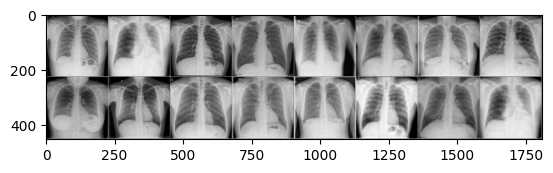

tensor([1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0])


In [9]:
imshow(torchvision.utils.make_grid(train_features))
print(train_labels)

## Creación de red
En esencia, se carga la arquitectura ResNet-18 con pesos pre-entrenados del enorme dataset ImageNet. Esto proporciona al modelo una poderosa capacidad para extraer características de las imágenes.
Se extraen todas las capas convolucionales de ResNet-18, excluyendo la última capa, que es la capa de clasificación original. Esta secuencia de capas ahora se almacena en self.features.
Se congelan los pesos de todas las capas convolucionales cargadas. Esto significa que, durante el entrenamiento futuro, estos pesos no se actualizarán (el gradiente no se calculará ni se aplicará). El modelo utilizará el conocimiento general de ImageNet y solo entrenará las capas nuevas que se añadan.










In [10]:
import torch
import torch.nn as nn
import torchvision.models as models

class SkinCancerClassifier(nn.Module):
    def __init__(self, num_classes=2):
        super(SkinCancerClassifier, self).__init__()
        # Carga de modelo pre-entrenado
        resnet18 = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

        # Eliminación de última capa modelo pre-entrenado
        self.features = nn.Sequential(*list(resnet18.children())[:-1])

        # Congelación de pesos del modelo
        for param in self.features.parameters():
            param.requires_grad = False

        # Nueva capa a entrenar
        num_ftrs = resnet18.fc.in_features
        self.classifier = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Instanciación de modelo y definición de número de clases
model = SkinCancerClassifier(num_classes=2)

# Mover modelo a GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print(model)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:01<00:00, 44.3MB/s]


SkinCancerClassifier(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runni

## Entrenamiento de red

In [11]:
import torch.optim as optim
import torch.nn as nn

# Definición de optimizador y función de perdida
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

Para entrenar el modelo iterativamente durante 30 épocas (num_epochs = 30), ajusta sus pesos y evalua su rendimiento después de cada época, registrando las métricas de pérdida (loss) y precisión (accuracy), tanto para entrenamiento como validacion.


In [13]:
num_epochs = 30  # Ajustar y testear diferentes muestras
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    # Fase de entrenamiento
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for i, data in enumerate(train_dataloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_train_loss = running_loss / len(train_dataloader)
    epoch_train_accuracy = 100 * correct_train / total_train
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_accuracy)

    # Fase de validación
    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for i, data in enumerate(val_dataloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    epoch_val_loss = running_val_loss / len(val_dataloader)
    epoch_val_accuracy = 100 * correct_val / total_val
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_accuracy)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_accuracy:.2f}%, Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_accuracy:.2f}%')

print('Finished Training')

Epoch 1/30, Train Loss: 0.6784, Train Acc: 58.56%, Val Loss: 0.7167, Val Acc: 47.75%
Epoch 2/30, Train Loss: 0.6334, Train Acc: 62.16%, Val Loss: 0.6648, Val Acc: 58.56%
Epoch 3/30, Train Loss: 0.6316, Train Acc: 63.96%, Val Loss: 0.6483, Val Acc: 55.86%
Epoch 4/30, Train Loss: 0.6176, Train Acc: 63.06%, Val Loss: 0.6678, Val Acc: 52.25%
Epoch 5/30, Train Loss: 0.6111, Train Acc: 68.47%, Val Loss: 0.6676, Val Acc: 54.95%
Epoch 6/30, Train Loss: 0.6033, Train Acc: 65.77%, Val Loss: 0.6659, Val Acc: 56.76%
Epoch 7/30, Train Loss: 0.5839, Train Acc: 70.27%, Val Loss: 0.6472, Val Acc: 61.26%
Epoch 8/30, Train Loss: 0.5841, Train Acc: 74.77%, Val Loss: 0.6246, Val Acc: 63.06%
Epoch 9/30, Train Loss: 0.5816, Train Acc: 71.17%, Val Loss: 0.6114, Val Acc: 67.57%
Epoch 10/30, Train Loss: 0.5638, Train Acc: 81.98%, Val Loss: 0.5857, Val Acc: 78.38%
Epoch 11/30, Train Loss: 0.5893, Train Acc: 72.07%, Val Loss: 0.5584, Val Acc: 82.88%
Epoch 12/30, Train Loss: 0.5528, Train Acc: 76.58%, Val Loss: 0

Este código tiene el propósito de visualizar y analizar el rendimiento del modelo de clasificación a lo largo de las 30 épocas de entrenamiento que se ejecutaron en el paso anterior.

Utiliza la librería Matplotlib para generar dos gráficos de línea que son fundamentales en el Deep Learning para diagnosticar problemas como el sobreajuste (overfitting) o el subajuste (underfitting).

El Gráfico de Precisión (Accuracy) muestra cómo mejora la capacidad del modelo para hacer predicciones correctas. Este gráfico ayuda a ver si el modelo está aprendiendo. La precisión de ambas líneas debería aumentar. Si la línea de entrenamiento sigue subiendo mientras la de validación se estanca o cae, esto es una señal clara de sobreajuste.

El Gráfico de Pérdida (Loss)
Muestra cómo disminuye el error (pérdida) del modelo durante el entrenamiento.
Ambos valores de pérdida deberían disminuir a medida que avanza el entrenamiento. Si la pérdida de validación comienza a subir (mientras que la de entrenamiento sigue bajando), esto también indica sobreajuste, ya que el modelo está memorizando el conjunto de entrenamiento en lugar de generalizar.

En resumen, el código permite una evaluación visual crítica del proceso de entrenamiento, lo cual es esencial para decidir si el modelo está listo o si necesita ajustes (como más datos, más épocas, o cambios en la tasa de aprendizaje).




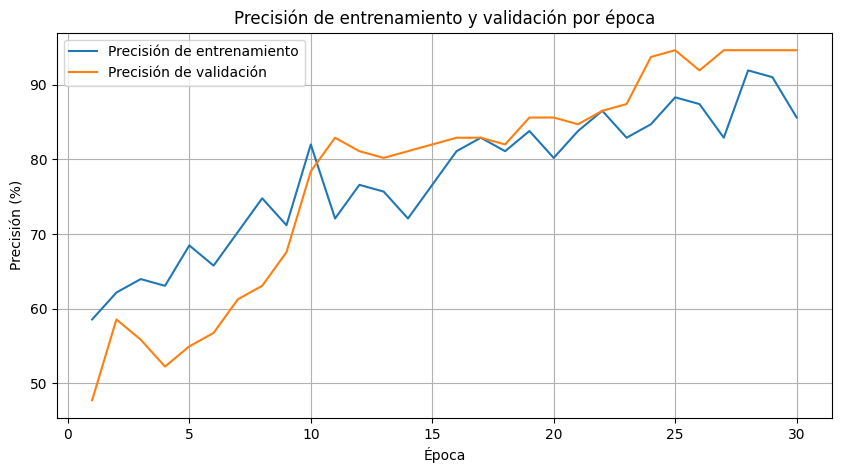

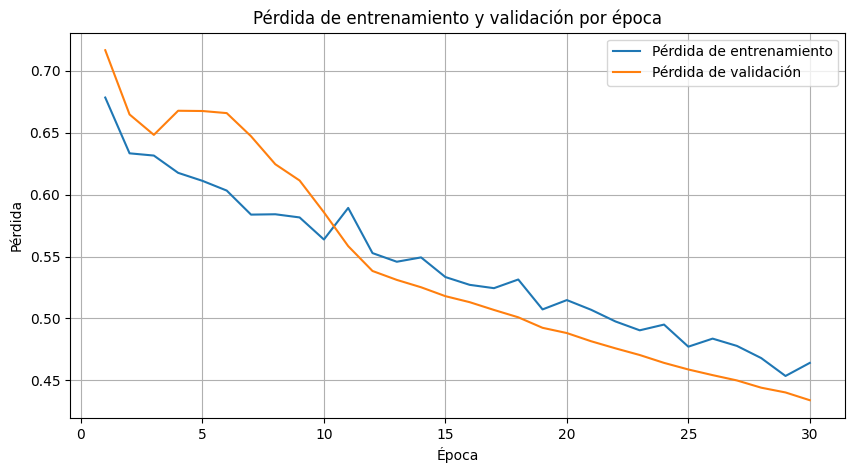

In [14]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Precisión de entrenamiento')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Precisión de validación')
plt.xlabel('Época')
plt.ylabel('Precisión (%)')
plt.title('Precisión de entrenamiento y validación por época')
plt.legend()
plt.grid(True)
plt.show()

# Plot perdida
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Pérdida de entrenamiento')
plt.plot(range(1, num_epochs + 1), val_losses, label='Pérdida de validación')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.title('Pérdida de entrenamiento y validación por época')
plt.legend()
plt.grid(True)
plt.show()

## Evaluacion de métricas


In [15]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import torch

model.eval()

all_labels = []
all_outputs = []

# Inferencia en dataset de validación
with torch.no_grad():
    for inputs, labels in val_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)

        all_labels.extend(labels.cpu().numpy())
        all_outputs.extend(outputs.cpu().numpy())

all_outputs = torch.tensor(all_outputs)

# Binarización de etiquetas
_, all_predictions_binarized = torch.max(all_outputs, 1)

# Calculo de metricas
accuracy = accuracy_score(all_labels, all_predictions_binarized.numpy())
precision = precision_score(all_labels, all_predictions_binarized.numpy(), average='weighted')
recall = recall_score(all_labels, all_predictions_binarized.numpy(), average='weighted')
f1 = f1_score(all_labels, all_predictions_binarized.numpy(), average='weighted')

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')

Accuracy: 0.9459
Precision: 0.9505
Recall: 0.9459
F1-score: 0.9452


/tmp/ipython-input-1211146751.py:19: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  all_outputs = torch.tensor(all_outputs)


Este código realiza la evaluación del modelo de clasificación.Su función principal es realizar la inferencia sobre todos los datos de validación y luego usar la librería Scikit-learn para obtener el Accuracy, Precision, Recall y la F1-score.

El código utiliza las funciones de la librería Scikit-learn para comparar las etiquetas reales (all_labels) con las predicciones binarias (all_predictions_binarized) y calcular las métricas:

Accuracy (accuracy_score): La métrica más simple; el porcentaje de predicciones correctas sobre el total.

Precision (precision_score): De todas las predicciones positivas hechas por el modelo, ¿cuántas fueron realmente correctas? Es clave cuando es riesgoso tener falsos positivos.

Recall (recall_score): De todos los casos positivos reales, ¿cuántos predijo el modelo correctamente? Es crucial en medicina (como la detección de cáncer) para minimizar los falsos negativos.

F1-score (f1_score): Es la media armónica de Precision y Recall. Proporciona un único número que equilibra la necesidad de tener precisión y cobertura.










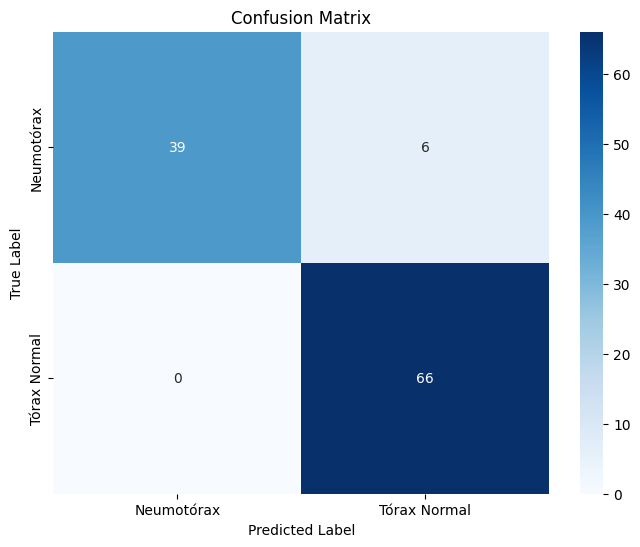

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions_binarized.numpy())

# Display the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=dataset_val.classes, yticklabels=dataset_val.classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

Esta ultima etapa se enfoca en la visualización grafica del rendimiento del modelo mediante la generación de una Matriz de Confusión.
Toma las etiquetas reales y las predicciones finales del modelo y las  presenta en un mapa de calor (heatmap) de Matplotlib/Seaborn.
En la diagonal primaria, muestra el número de predicciones correctas (Verdaderos Positivos VP y Verdaderos Negativos VN).
Y en la diagonal secundaria: Muestra los errores (Falsos Positivos FP y Falsos Negativos FN).

Utiliza una paleta de colores azul, donde la intensidad del color representa un mayor número de muestras en esa celda.
En resumen, esta representacion permite  ver graficamente si hay sesgos hace un tipo de error.


## RESULTADOS
Para una adecuada evaluacion de las metricas debemos tomar en cuanta que la patologia de neumotorax es una patologia aguda de urgencia, por lo que requerimos un modelo que maximinice el Recall ( sensibilidad) y por tanto que minimice los falsos negativos, es decir, pacientes que teniendo neumotorax, el modelo los clasifica como normales.
Tomando esto en consideracion el modelo muestra un Recall (Sensibilidad) de un 0.9459. El modelo detecta correctamente el 94.59% de todos los casos reales de neumotorax (Verdaderos Positivos).	El 5,41% de los casos reales de neumotorax no se estan clasificando adecuadamente (Falsos Negativos). Este valor debiera ser mejorado.

Precision	0.9505	De todas las veces que el modelo predijo "neumotorax", acertó en el 95.057% de las veces.	El 4.95% de las predicciones de neumotorax son Falsos Positivos. Esto puede lleva a procedimientos innecesarios, con la consistente anciedad para el paciente y familiares.
Para una clasificación médica, idealmente buscamos un alto Recall, aunque sacrifiquemos un poco la Precision.

F1-score entrego valores de (0.9452), este valor es una media armónica de equilibrio entre Precision y Recall. El hecho de que sea el valor un poco mas bajo, podria indicar que el modelo tiene cierto desequilibrio. En este caso, el F1-score es ligeramente inferior al Recall, sugiriendo que la precisión también está arrastrando el rendimiento general.

Accuracy mostro valores de (0.9459),  la precisión global es consistente con el Recall, el Accuracy es menos fiable si los datos no están perfectamente equilibrados. En este caso hay una relacion 60/40 entre imagenes normales y con Neumotorax

Con respecto al gráfico de Precisión (Accuracy) muestra cómo mejora la capacidad del modelo para hacer predicciones correctas, ambas lineas aumentan en conjunto, no mostrando signos de sobreajuste.

El Gráfico de Pérdida (Loss) por su lado muestra cómo disminuye el error (pérdida) del modelo durante el entrenamiento. Tanto la curva de  perdida de validacion como de entrenamiento bajan en conjunto.

Se probo modificando con learning rates mas bajos a 0.00001, y 15-20 épocas, como sugirio el profesor pero las metricas no mejoraron, al contrario bajaron sus valores. Y lo que mejor resulto fue aumentar las epocas a 3o.

Creo que una de las debilidades del modelo es la cantidad de imagenes de entrenamiento que en total son 111, yo quise probar con imagenes reales y hacer el proceso completo de extraer las imagenes DICOM y hacer el entrenamiento del modelo. Trate de incluir una alta variabilidad tanto de tipos de neumotorax y de torax normales de adultos mayores de 18 años, pero es dificil representar en particular la alta variabilidad y dificultad que tiene este tipo de patologia.





##CONCLUSION
El rendimiento general del modelo (alrededor del 94-95%) lo que es razonable, pero para una aplicación médica, el 5-6% de Falsos Negativos (bajo Recall) es un riesgo moderado que debemos optimizar.

Creo que para mejorar el modelo, y seguir trabajando en el podriamos:
- Ajustar el Umbral de Clasificación del 50% al 40%, quizas esto podria hacer el modelo sea "más sensible" al neumotorax, lo que podria aumentará el Recall pero probablemente reducirá la Precision (más Falsos Positivos).

- Optimizar con Ponderación de Clases: Incorporar mas casos de nuemutorax para igualar los de torax normales o usar una función de pérdida ponderada (weighted loss) para penalizar más los errores en la clase minoritaria (neumotorax), lo que forzará al modelo a priorizar el Recall.

- Y por ultimo aumentar consistentemente los datos de entrenamiento, tratando de recolectar un n que supere los varios miles de estudios para cada categoria, o hacer subcategorias con tipos de neumotorax: apical, moderado, extenso, etc.

